In [2]:
import os.path
import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array ,ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import Dense,Dropout
from keras.preprocessing import image
from keras.models import Model
import zipfile
import cv2

In [5]:
!mkdir -p ~/.`kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/
!kaggle datasets download --force -d aryan401/indian-food-16

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aryan401/indian-food-16
License(s): Apache 2.0
 99% 1.47G/1.48G [00:18<00:00, 163MB/s]
100% 1.48G/1.48G [00:18<00:00, 85.2MB/s]


In [6]:
zip_ref = zipfile.ZipFile('/content/indian-food-16.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
train_dir=Path("/content/Train")
test_dir=Path("/content/Test")

train_filepaths=list(train_dir.glob(r'**/*.jpg'))
test_filepaths=list(test_dir.glob(r'**/*.jpg'))

In [8]:
val_dir=Path("/content/Validate")
val_filepaths=list(val_dir.glob(r'**/*.jpg'))

In [9]:
def image_processing(filepaths):
    filepaths = [str(filepath) for filepath in filepaths]
    labels = [str(filepath).split("/")[-2] for filepath in filepaths]
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [10]:
train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)
val_df=image_processing(val_filepaths)

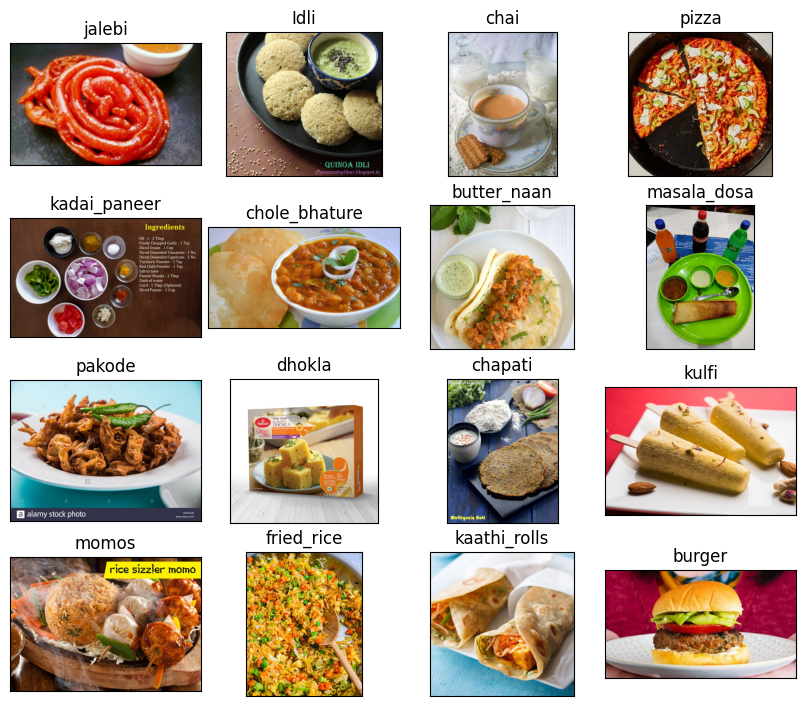

In [11]:
df_unique=train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(8,7),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.Filepath[i]))
  ax.set_title(df_unique.Label[i],fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()


In [12]:
train_generator=ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator=ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 4688 validated image filenames belonging to 20 classes.


In [14]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 687 validated image filenames belonging to 20 classes.


In [15]:
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0,
)

Found 1335 validated image filenames belonging to 20 classes.


In [16]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)
pretrained_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
last_output = pretrained_model.output
x = tf.keras.layers.Dense(128,activation='relu')(last_output)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dense(16,activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(16,activation='softmax')(x)

model = tf.keras.Model(inputs=pretrained_model.input,outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [24]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

num_classes = len(train_df['Label'].unique())
print("Number of classes in training data:", num_classes)


outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Number of classes in training data: 20
Epoch 1/5
147/147 [==============================] - 296s 2s/step - loss: 1.2163 - accuracy: 0.6557 - val_loss: 0.6792 - val_accuracy: 0.8035
Epoch 2/5
147/147 [==============================] - 297s 2s/step - loss: 0.5444 - accuracy: 0.8392 - val_loss: 0.6604 - val_accuracy: 0.8151
Epoch 3/5
147/147 [==============================] - 290s 2s/step - loss: 0.3366 - accuracy: 0.9034 - val_loss: 0.6595 - val_accuracy: 0.8224
Epoch 4/5
147/147 [==============================] - 301s 2s/step - loss: 0.2243 - accuracy: 0.9337 - val_loss: 0.5684 - val_accuracy: 0.8413
Epoch 5/5
147/147 [==============================] - 274s 2s/step - loss: 0.1297 - accuracy: 0.9654 - val_loss: 0.6704 - val_accuracy: 0.8311


In [25]:
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

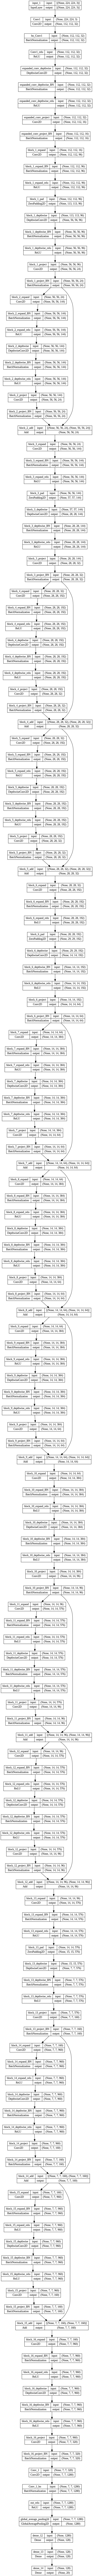

In [34]:

tf.keras.utils.plot_model(model, show_shapes=True)


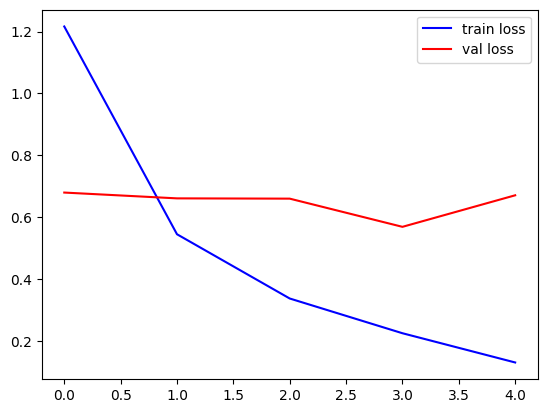

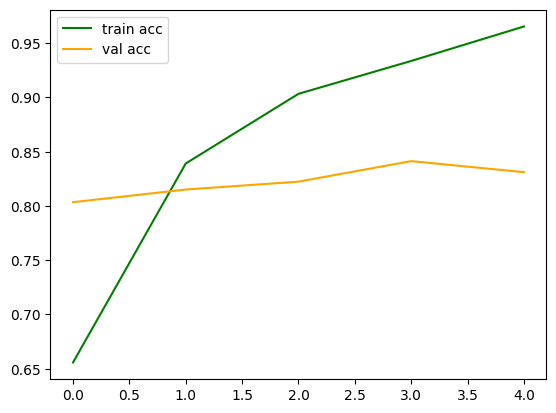

<Figure size 640x480 with 0 Axes>

In [35]:
plt.plot(history.history['loss'], label='train loss', color='blue')
plt.plot(history.history['val_loss'], label='val loss', color='red')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='train acc', color='green')
plt.plot(history.history['val_accuracy'], label='val acc', color='orange')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [27]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

42/42 [==============================] - 66s 2s/step


['samosa',
 'pizza',
 'chai',
 'chai',
 'dhokla',
 'paani_puri',
 'chai',
 'kadai_paneer',
 'momos',
 'chapati',
 'Idli',
 'dhokla',
 'pizza',
 'chole_bhature',
 'paani_puri',
 'jalebi',
 'dal_makhani',
 'dhokla',
 'kadai_paneer',
 'pav_bhaji',
 'fried_rice',
 'masala_dosa',
 'chai',
 'pakode',
 'momos',
 'jalebi',
 'jalebi',
 'fried_rice',
 'momos',
 'Idli',
 'chai',
 'burger',
 'dhokla',
 'dal_makhani',
 'Idli',
 'dhokla',
 'masala_dosa',
 'burger',
 'kulfi',
 'kaathi_rolls',
 'pakode',
 'chole_bhature',
 'chole_bhature',
 'dhokla',
 'dal_makhani',
 'Idli',
 'jalebi',
 'kulfi',
 'Idli',
 'fried_rice',
 'chole_bhature',
 'Idli',
 'pav_bhaji',
 'chole_bhature',
 'kaathi_rolls',
 'chai',
 'kulfi',
 'kadai_paneer',
 'dal_makhani',
 'pakode',
 'Idli',
 'kadai_paneer',
 'dhokla',
 'kadai_paneer',
 'butter_naan',
 'pakode',
 'kaathi_rolls',
 'dhokla',
 'paani_puri',
 'chole_bhature',
 'dhokla',
 'kadai_paneer',
 'fried_rice',
 'Idli',
 'momos',
 'pakode',
 'pav_bhaji',
 'chai',
 'Idli',
 'f

In [28]:
def output(location):
  img=load_img(location,target_size=(224,224,3))
  img=img_to_array(img)
  img=img/255
  img=np.expand_dims(img,[0])
  answer=model.predict(img)
  y_class=answer.argmax(axis=-1)
  y=" ".join(str(x) for x in y_class)
  y=int(y)
  res=labels[y]
  return res

1/1 [==============================] - 0s 51ms/step


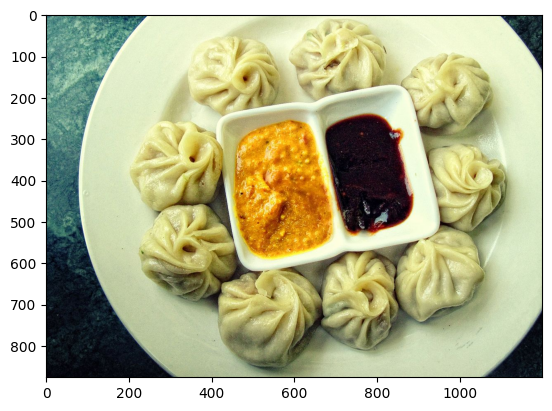

momos


In [41]:
import matplotlib.image as mpimg
location = '/content/Test/momos/001.jpg'
result = output(location)
img = mpimg.imread('/content/Test/momos/001.jpg')
imgplot = plt.imshow(img)
plt.show()
print(result)


1/1 [==============================] - 0s 54ms/step


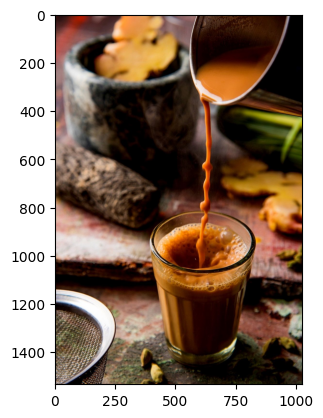

chai


In [43]:
location = '/content/Test/chai/032.jpg'
result = output(location)
img = mpimg.imread('/content/Test/chai/032.jpg')
imgplot = plt.imshow(img)
plt.show()
print(result)


1/1 [==============================] - 0s 52ms/step


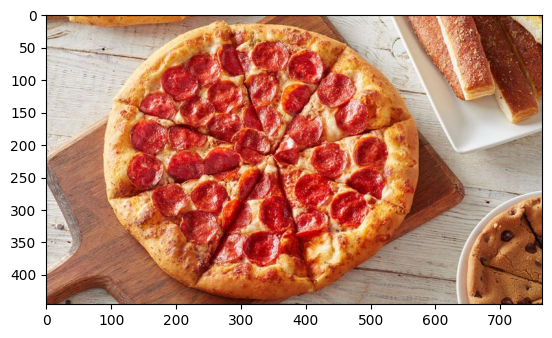

pizza


In [46]:
location = '/content/Test/pizza/009.jpg'
result = output(location)
img = mpimg.imread('/content/Test/pizza/009.jpg')
imgplot = plt.imshow(img)
plt.show()
print(result)
